In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from utils import show_graph

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
def train():
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    history = []
    iterep = 500
    for i in range(iterep * 30):
        x_train, y_train = mnist.train.next_batch(100)
        sess.run(train_step,
                 feed_dict={'x:0': x_train, 
                            'y:0': y_train, 
                            'phase:0': 1})
        if (i + 1) %  iterep == 0:
            epoch = (i + 1)/iterep
            tr = sess.run([loss, accuracy], 
                          feed_dict={'x:0': mnist.train.images,
                                     'y:0': mnist.train.labels,
                                     'phase:0': 1})
            t = sess.run([loss, accuracy], 
                         feed_dict={'x:0': mnist.test.images,
                                    'y:0': mnist.test.labels,
                                    'phase:0': 0})
            history += [[epoch] + tr + t]
            print(history[-1]) 
    return history

# No batch normalization

In [6]:
def dense(x, size, scope):
    return tf.contrib.layers.fully_connected(x, size, 
                                             activation_fn=None,
                                             scope=scope)

def dense_relu(x, size, scope):
    with tf.variable_scope(scope):
        h1 = dense(x, size, 'dense')
        return tf.nn.relu(h1, 'relu')

In [7]:
tf.reset_default_graph()
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

h1 = dense_relu(x, 100, 'layer1')
h2 = dense_relu(h1, 100, 'layer2')
logits = dense(h2, 10, scope='logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

In [8]:
show_graph(tf.get_default_graph().as_graph_def())

In [9]:
history = train()

[1.0, 0.59787625, 0.85439998, 0.57166916, 0.86369997]
[2.0, 0.40848014, 0.88916361, 0.38908702, 0.89310002]
[3.0, 0.34938169, 0.90176362, 0.3317017, 0.90600002]
[4.0, 0.31603843, 0.9097091, 0.3008475, 0.91289997]
[5.0, 0.29332247, 0.91621816, 0.27973101, 0.92129999]
[6.0, 0.27449208, 0.92163634, 0.26406002, 0.92519999]
[7.0, 0.26136065, 0.92494547, 0.25107485, 0.9289]
[8.0, 0.24650002, 0.92940003, 0.23732984, 0.93229997]
[9.0, 0.23352818, 0.93314546, 0.22644238, 0.93519998]
[10.0, 0.22393693, 0.93592727, 0.21786919, 0.93709999]
[11.0, 0.21545361, 0.93879998, 0.21021445, 0.93879998]
[12.0, 0.20569164, 0.94169092, 0.20155698, 0.9411]
[13.0, 0.19759855, 0.94401819, 0.19364727, 0.94370002]
[14.0, 0.19050767, 0.94561815, 0.18776415, 0.94510001]
[15.0, 0.18358779, 0.94781816, 0.18138421, 0.94800001]
[16.0, 0.1774399, 0.9495818, 0.17794454, 0.94870001]
[17.0, 0.17194457, 0.95092726, 0.17245024, 0.95029998]
[18.0, 0.16642514, 0.95225453, 0.16627178, 0.95139998]
[19.0, 0.16317457, 0.95329088, 0

# Standard batch normalization

In [10]:
def dense_batch_relu(x, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, 100, activation_fn=None, scope='dense')
        h2 = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training=phase,
                                          scope='bn')
        return tf.nn.relu(h2, 'relu')

In [12]:
tf.reset_default_graph()
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

h1 = dense_batch_relu(x, phase,'layer1')
h2 = dense_batch_relu(h1, phase, 'layer2')
logits = dense(h2, 10, 'logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

In [13]:
show_graph(tf.get_default_graph().as_graph_def())

In [14]:
history_bn = train()

[1.0, 0.40454552, 0.89910907, 1.1906044, 0.86019999]
[2.0, 0.28410548, 0.92592728, 0.70298308, 0.91409999]
[3.0, 0.23150659, 0.93823636, 0.42222559, 0.93610001]
[4.0, 0.19936745, 0.94603634, 0.28978595, 0.94400001]
[5.0, 0.17622821, 0.95249093, 0.22080454, 0.9501]
[6.0, 0.15878969, 0.95656365, 0.18653113, 0.9533]
[7.0, 0.14486809, 0.96029091, 0.16512275, 0.95730001]
[8.0, 0.13278662, 0.96392727, 0.1542986, 0.95969999]
[9.0, 0.12280951, 0.96696365, 0.14220725, 0.96079999]
[10.0, 0.11415016, 0.96936363, 0.13642164, 0.96280003]
[11.0, 0.1067225, 0.97176361, 0.13093872, 0.96240002]
[12.0, 0.099903271, 0.97320002, 0.12428293, 0.96359998]
[13.0, 0.094025411, 0.97523636, 0.11801069, 0.96560001]
[14.0, 0.088162571, 0.97747272, 0.11338492, 0.96700001]
[15.0, 0.083216265, 0.97845453, 0.11048675, 0.96789998]
[16.0, 0.078705259, 0.97972727, 0.10797473, 0.9677]
[17.0, 0.07461261, 0.98074543, 0.10553361, 0.96920002]
[18.0, 0.070660166, 0.98209089, 0.1027493, 0.97039998]
[19.0, 0.067435138, 0.9827454

# Post-activation batch normalization

In [15]:
def dense_relu_batch(x, phase, scope):
    with tf.variable_scope(scope):
        h1 = dense_relu(x, 100, scope='dense_relu')
        bn = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training=phase,
                                          scope='bn')
        return bn

In [17]:
tf.reset_default_graph()
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

h1 = dense_relu_batch(x, phase,'layer1')
h2 = dense_relu_batch(h1, phase, 'layer2')
logits = dense(h2, 10, 'logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

In [18]:
show_graph(tf.get_default_graph().as_graph_def())

In [19]:
history_post_bn = train()

[1.0, 0.29695031, 0.91943634, 1.2344837, 0.86489999]
[2.0, 0.21808814, 0.93925452, 0.82191652, 0.90960002]
[3.0, 0.17976156, 0.94985455, 0.52802318, 0.92830002]
[4.0, 0.15418938, 0.95683634, 0.34713745, 0.94129997]
[5.0, 0.13658845, 0.96149093, 0.24450167, 0.94859999]
[6.0, 0.12179869, 0.9660182, 0.18545027, 0.95480001]
[7.0, 0.11047582, 0.9691273, 0.15663777, 0.95749998]
[8.0, 0.10128638, 0.97254544, 0.13842614, 0.96090001]
[9.0, 0.092830561, 0.97521818, 0.12527834, 0.96280003]
[10.0, 0.086472109, 0.97685456, 0.11942355, 0.96399999]
[11.0, 0.079783969, 0.97912729, 0.11234903, 0.96640003]
[12.0, 0.074044757, 0.98032725, 0.10807349, 0.96609998]
[13.0, 0.069018155, 0.98209089, 0.10411943, 0.96789998]
[14.0, 0.065023348, 0.98280001, 0.10173881, 0.96890002]
[15.0, 0.060619425, 0.98476362, 0.099617742, 0.96960002]
[16.0, 0.057120606, 0.98570907, 0.097526431, 0.97060001]
[17.0, 0.053344406, 0.98669094, 0.0958286, 0.97000003]
[18.0, 0.050334454, 0.98767275, 0.095316738, 0.97039998]
[19.0, 0.0

# Evaluation

In [21]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [22]:
history = np.array(history)
history_bn = np.array(history_bn)
history_post_bn = np.array(history_post_bn)

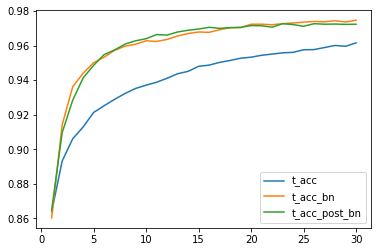

In [23]:
plt.plot(history[:, 0], history[:, -1], label='t_acc')
plt.plot(history_bn[:, 0], history_bn[:, -1], label='t_acc_bn')
plt.plot(history_post_bn[:, 0], history_post_bn[:, -1], label='t_acc_post_bn')
plt.legend()